In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import config
config.USE_CUDA = False
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
from model import IRLC
import torch

model = IRLC()
model.load_state_dict(torch.load("./saved_models/hope-epoch-80-acc-0.5452399849891663"))
model.eval()
None

initialising with glove embeddings
done.


In [6]:
import torch
import numpy as np
import _pickle as pkl
import json
import h5py
from dataset import Dictionary
from PIL import Image # to load
from IPython.display import display # to display
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class DummyLoader:
    mode = "train"
    def __init__(self):
        self.h5_loc = "./data/{}36.hdf5".format(self.mode)
        self.question_path = './data/v2_OpenEnded_mscoco_{}2014_questions.json'.format(self.mode)
        self.imgid2idx_loc = "./data/{}36_imgid2idx.pkl".format(self.mode)
        
        self.qid2count = json.load(open("./data/how_many_qa/qid2count.json", "rb"))["train"]["vqa"]
        self.dictionary = Dictionary.load_from_file('data/dictionary.pkl')
        self.imgid2idx = pkl.load(open(self.imgid2idx_loc, "rb"))
        self.questions = sorted(json.load(open(self.question_path))['questions'], key=lambda x: x['question_id'])
        
        self.valid_qids = set(self.qid2count.keys())
        self.questions = [entry for entry in self.questions if str(entry["question_id"]) in self.valid_qids]
        
        
    def tokenize(self, question, max_length=14):
        """Tokenizes the questions.

        This will add q_token in each entry of the dataset.
        -1 represent nil, and should be treated as padding_idx in embedding
        """
        tokens = self.dictionary.tokenize(question, False)
        tokens = tokens[:max_length]
        if len(tokens) < max_length:
            # Note here we pad in front of the sentence
            padding = [self.dictionary.padding_idx] * (max_length - len(tokens))
            tokens = padding + tokens
        assert len(tokens) == max_length
        return tokens
    
    def get_image_features(self, idx):
        with h5py.File(self.h5_loc, 'r') as hf:
            v = hf["image_features"][idx]
            b = hf["spatial_features"][idx]
        return v, b  # (k, 2048), (k, 6)
    
    def show_entry(self, idx):
        entry = self.questions[idx]
        question = entry["question"]
        image_coco_id = entry["image_id"]
        image_loc = '/tmp/train2014/COCO_train2014_%012d.jpg' % image_coco_id
#         image = Image(filename=image_loc)
        gt_count = self.qid2count[str(entry["question_id"])]
        return question, gt_count, image_loc
    
    def get_entry(self, idx):
        
        entry = self.questions[idx]
        q = self.tokenize(entry['question'])
        image_coco_id = entry["image_id"]
        img_idx = self.imgid2idx[image_coco_id]
        v, b = self.get_image_features(img_idx)
        
        q = torch.from_numpy(np.array(q))[None]
        v = torch.from_numpy(np.array(v))[None]
        b = torch.from_numpy(np.array(b))[None]
        
        return q, v, b
        


In [7]:
def draw_box_probs(img_loc, box_probs=None, selected_boxes=None):
#     im = np.array(Image.open('/tmp/train2014/COCO_train2014_%012d.jpg' % 9), dtype=np.uint8)
    im = np.array(Image.open(img_loc), dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # Display the image
    ax.imshow(im)
    h, w, _ = im.shape
    
    if box_probs is not None:
        for box, prob in box_probs:
            x = box[0] * w
            y = box[1] * h
            x_w = box[4] * w
            y_w = box[5] * h

            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), x_w, y_w,linewidth=2,edgecolor='b',facecolor='none', alpha=prob)

            # Add the patch to the Axes
            ax.add_patch(rect)
    
    if selected_boxes is not None:
        for box, _ in selected_boxes:
            x = box[0] * w
            y = box[1] * h
            x_w = box[4] * w
            y_w = box[5] * h

            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), x_w, y_w,linewidth=2,edgecolor='r',facecolor='none', alpha=1)

            # Add the patch to the Axes
            ax.add_patch(rect)

    plt.show()

In [8]:
dl = DummyLoader()

loading dictionary from data/dictionary.pkl


In [9]:
def visualize(idx):
    q, v, b = dl.get_entry(idx)
    kappa_0, rho = model.compute_vars(v, b, q)
    count, greedy_count, logPA, entP, A, rho, P = model.take_mc_samples(kappa_0, rho, 1)
    P = P[:, 0, :]
    A = A[:, 0]
    ques, gt_count, image_loc = dl.show_entry(idx)
      
    print("ques: {}".format(ques))
    print("ans: {}".format(gt_count))
    print("pred: {}".format(count))
    
    draw_box_probs(image_loc)

    cands = zip(b[0], 0 * P[0] + 1)
    draw_box_probs(image_loc, cands)
    sels = []
    for t in range(0, 36):
        cands = zip(b[0], P[t])
        draw_box_probs(image_loc, cands, sels)

        selection = A[t]
        if selection == 36:
            break
        sels.append((b[0][selection], None))
        
    return

ques: How many sheepskin are grazing?
ans: 4
pred: tensor([ 4])


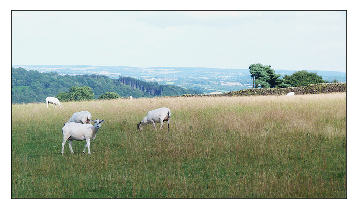

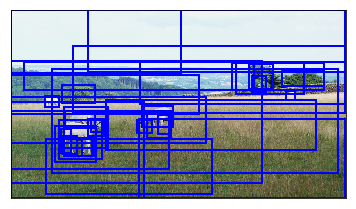

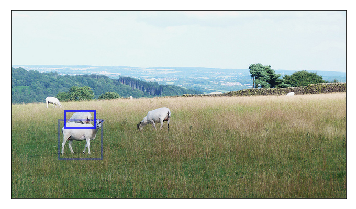

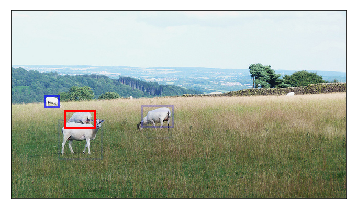

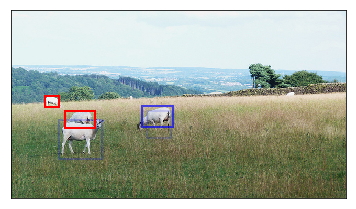

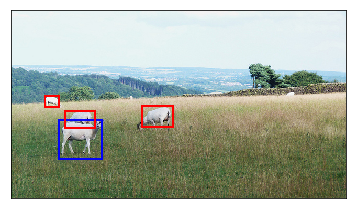

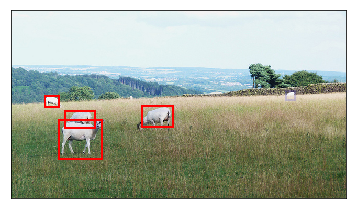

In [10]:
visualize(335)

ques: How many people are present?
ans: 2
pred: tensor([ 2])


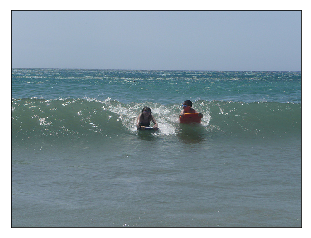

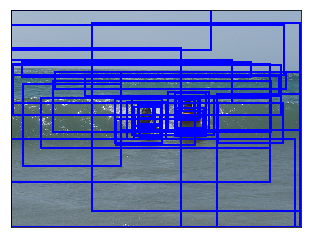

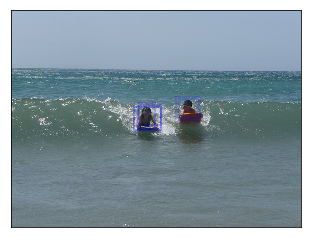

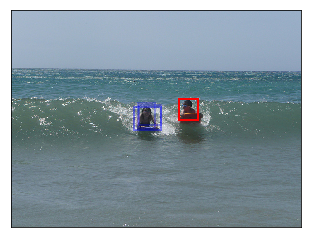

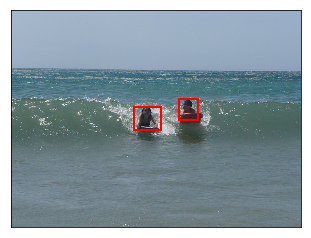

In [11]:
visualize(364)